In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from WindPy import w
%matplotlib inline

In [38]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

## 获取起始日期

In [39]:
today = datetime.datetime.today()

In [40]:
today.strftime('%Y-%m-%d')

'2019-03-25'

In [41]:
start_date = today - datetime.timedelta(365) # 最近1年

In [42]:
start_date.strftime('%Y-%m-%d')

'2018-03-25'

## 获取数据

In [43]:
df = pd.read_excel(u'../data/资产与宏观数据.xlsx')

In [44]:
df

,Variables,Name,Assets
0,M0001385,M2同比,000300.SH
1,M0001383,M1同比,000905.SH
2,M0000545,工业增加值同比,881001.WI
3,M5525763,社融同比,CBA00602.CS
4,M0017128,PMI新订单,CBA02002.CS
5,M0000605,进出口同比,AU9999.SGE
6,M0001428,社消同比,HSI.HI


In [45]:
var2name = {k: v for k, v in zip(df['Variables'], df['Name'])}

In [46]:
data = w.wsd(df['Assets'].tolist()[:7], 'close', start_date, today)

In [47]:
price = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)
price.index = pd.to_datetime(price.index)

In [48]:
price.tail()

,000300.SH,000905.SH,881001.WI,CBA00602.CS,CBA02002.CS,AU9999.SGE,HSI.HI
2019-03-19,3833.9626,5522.1801,4221.8907,118.3324,79.7530,285.20,29466.28
2019-03-20,3835.4397,5515.7856,4221.3026,118.2893,79.7427,284.59,29320.97
2019-03-21,3836.8913,5589.4780,4246.9516,118.3613,79.7518,286.50,29071.56
2019-03-22,3833.8013,5622.1402,4254.6575,118.5079,79.7608,286.50,29113.36
2019-03-25,3833.8013,5622.1402,4254.6575,118.5079,79.7608,286.50,29113.36


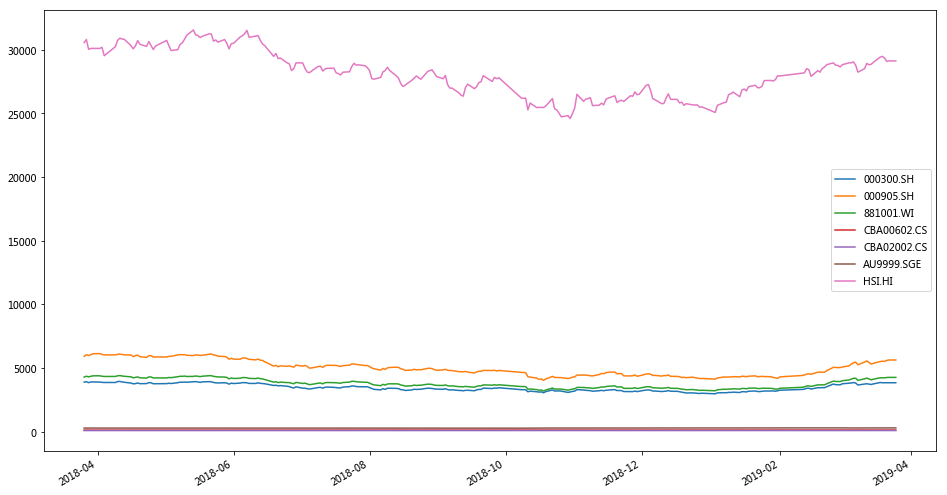

In [49]:
price.plot(figsize=(16, 9))

In [50]:
macro_variables = [x for x in df['Variables'] if str(x).find('.') == -1 and str(x) != 'nan']

In [51]:
macro_variables

[u'M0001385',
 u'M0001383',
 u'M0000545',
 u'M5525763',
 u'M0017128',
 u'M0000605',
 u'M0001428']

In [52]:
data = w.edb(macro_variables, start_date, today)

In [53]:
macro_df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=[var2name[x] for x in macro_variables])

In [54]:
macro_df

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
2018-03-31,8.2,7.1,6.000000,11.917040,53.3,5.30,10.100000
2018-04-30,8.3,7.2,7.000000,11.886410,52.9,16.50,9.400000
2018-05-31,8.3,6.0,6.800000,11.591320,53.8,18.19,8.500000
2018-06-30,8.0,6.6,6.000000,11.101210,53.2,12.07,9.000000
2018-07-31,8.5,5.1,6.000000,10.840980,52.3,18.27,8.800000
2018-08-31,8.2,3.9,6.100000,10.802550,52.2,14.51,9.000000
2018-09-30,8.3,4.0,5.800000,10.575280,52.0,14.11,9.200000
2018-10-31,8.0,2.7,5.900000,10.224710,50.8,17.00,8.600000
2018-11-30,8.0,1.5,5.400000,9.873883,50.4,3.44,8.100000
2018-12-31,8.1,1.5,5.700000,9.776316,49.7,-5.90,8.160814


In [55]:
macro_nav = (1+macro_df.pct_change()).cumprod()
macro_nav.iloc[0] = 1

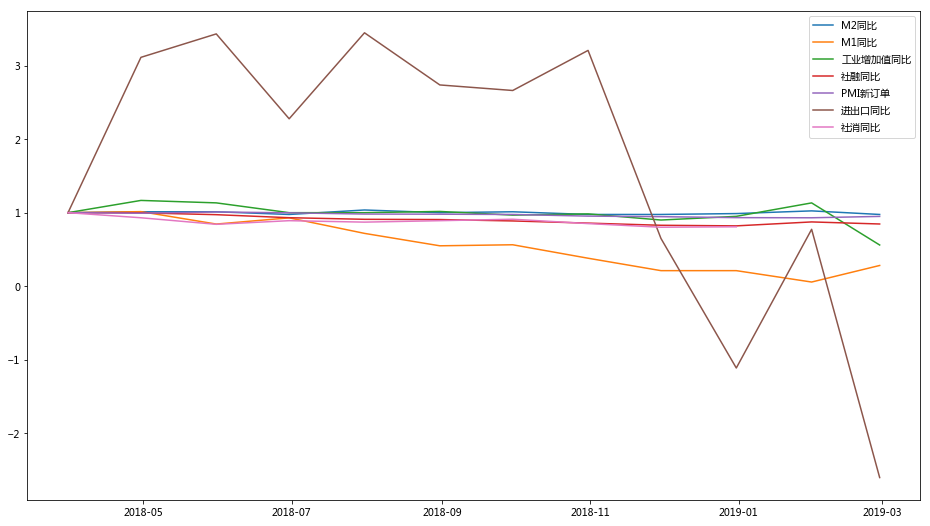

In [56]:
macro_nav.plot(figsize=(16, 9))

In [57]:
macro_df.to_excel('../data/macro_nav.xlsx')

In [58]:
ret_df = pd.DataFrame()

In [59]:
ret_df[u'成长股'] = price['000905.SH'].pct_change()
ret_df[u'价值股'] = price['000300.SH'].pct_change()
ret_df[u'港股'] = price['HSI.HI'].pct_change()
ret_df[u'黄金'] = price['AU9999.SGE'].pct_change()
ret_df[u'国债'] = price['CBA00602.CS'].pct_change()
ret_df[u'信用债'] = price['CBA02002.CS'].pct_change()

## 生成EWMA相关性矩阵

In [60]:
cor_df = pd.DataFrame(index= ret_df.columns, columns=macro_df.columns.tolist())

In [61]:
for asset in cor_df.index:
    for var in cor_df.columns:
        if var in macro_df.columns:
            s, t = (1+ret_df[asset]).cumprod().resample('M').last(), (1+macro_df[var].pct_change()).cumprod()
            corr = s.ewm(alpha=0.02, ignore_na=True, adjust=True).corr(t)
            cor_df.loc[asset, var] = corr[-1]

In [62]:
cor_df

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
成长股,0.280138,0.881046,0.177799,0.87169,0.875393,0.401351,0.526215
价值股,0.257425,0.721919,-0.0195475,0.759489,0.756098,0.235339,0.405387
港股,0.451296,0.681832,0.221671,0.827476,0.722548,0.261167,0.463057
黄金,-0.204273,-0.754635,-0.387053,-0.588443,-0.809228,-0.826051,-0.781235
国债,-0.176018,-0.799784,-0.4199,-0.685569,-0.845169,-0.839474,-0.82266
信用债,-0.144839,-0.870385,-0.465202,-0.696418,-0.901543,-0.792976,-0.684663


In [63]:
cor_df.to_excel('../data/macro_ewma_cor.xlsx')

In [64]:
trend = {}
for var in cor_df.columns:
    if var in macro_df.columns:
        t = macro_df[var]
    ret = t.pct_change()
    up, down = ret[ret > 0].sum(), -ret[ret < 0].sum()
    smooth = 1e-2
    if up > down:
        trend[var] = (up + smooth) / (down + smooth)
    else:
        trend[var] = -(down + smooth) / (up + smooth)

In [65]:
for k, v in trend.iteritems():
    print k, v

PMI新订单 -2.0809911320832537
M2同比 -1.1282209218984034
工业增加值同比 -1.7347416773827022
社融同比 -3.14093520602799
进出口同比 -3.4486859707975848
M1同比 1.9373032968070665
社消同比 -2.5430204206658606


In [66]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

In [67]:
board = pd.DataFrame(index=cor_df.index, columns=cor_df.columns)
for var in cor_df.columns:
#     print var
    x = cor_df[var] * trend[var]
    board[var] = sigmoid(x.astype(np.float32))

In [68]:
trend_df = pd.DataFrame(trend, index=[u'变量趋势'])

In [69]:
board = trend_df.append(board)

In [70]:
board = board[cor_df.columns]

In [71]:
board

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
变量趋势,-1.128221,1.937303,-1.734742,-3.140935,-2.080991,-3.448686,-2.543020
成长股,0.421637,0.846428,0.423497,0.060772,0.139232,0.200346,0.207810
价值股,0.427898,0.801958,0.508477,0.084285,0.171728,0.307548,0.262908
港股,0.375390,0.789334,0.405032,0.069200,0.181887,0.288910,0.235491
黄金,0.557363,0.188168,0.661825,0.863923,0.843433,0.945256,0.879393
国债,0.549484,0.175170,0.674458,0.895979,0.853058,0.947603,0.890127
信用债,0.540762,0.156276,0.691471,0.899113,0.867163,0.939045,0.850828


In [72]:
board.to_excel('../data/macro_dashboard.xlsx')